# Install and import dependencies

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

Load imports

In [1]:
from transformers import pipeline

from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, LangDetectException

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load classifier

In [2]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", revision="c626438", device="mps")

In [3]:
sample_rename_mappings = {
  "Interested in products or services": "random",
  "Requests": "video request",
  "Compliments": "compliment",
  "Questions (can be potential leads)": "question",
  "Hate Speech": "hate_speech",
  "Random": "random",
  "Problems with products or services": "problem"
}
classifier_labels = [v for k,v in sample_rename_mappings.items()]

In [4]:
result = classifier(
    "Dear Marina,I just wanted to say a big thank you for your amazing YouTube content that has helped me improve my English so much! 🙌📚 Your videos are awesome, and I'm truly grateful for all the valuable lessons and tips you share. Keep up the fantastic work! 💓👏🌟",
    candidate_labels=classifier_labels,
)
result


{'sequence': "Dear Marina,I just wanted to say a big thank you for your amazing YouTube content that has helped me improve my English so much! 🙌📚 Your videos are awesome, and I'm truly grateful for all the valuable lessons and tips you share. Keep up the fantastic work! 💓👏🌟",
 'labels': ['compliment',
  'video request',
  'question',
  'problem',
  'random',
  'random',
  'hate_speech'],
 'scores': [0.7603687047958374,
  0.15332449972629547,
  0.029150063171982765,
  0.022072985768318176,
  0.014438104815781116,
  0.014438104815781116,
  0.0062075089663267136]}

In [5]:
def process_text(text: str):
    classifications = classifier(text, classifier_labels)
    scores = classifications["scores"]

    return pd.Series({f"pred_{label}": score for label, score in zip(classifier_labels, scores)})

# Test classifier on sample dataset

In [6]:
df = pd.read_csv("sample.csv")
df.head()

,label,comment
0,Interested in products or services,"Yes Marina, It's essential for me to learn Eng..."
1,Interested in products or services,That's what I've always wanted
2,Interested in products or services,I am not a professional guy. I am just studyin...
3,Interested in products or services,Do you think it's still essential to learn Eng...
4,Interested in products or services,"Hi Marina, thanks for sharing these useful vid..."


In [7]:
y = "label"

# Rename labels
df[y] = df[y].replace(sample_rename_mappings)

df[y].value_counts()

label
random           15
video request     8
compliment        8
question          5
hate_speech       2
Name: count, dtype: int64

Total number of samples: 38


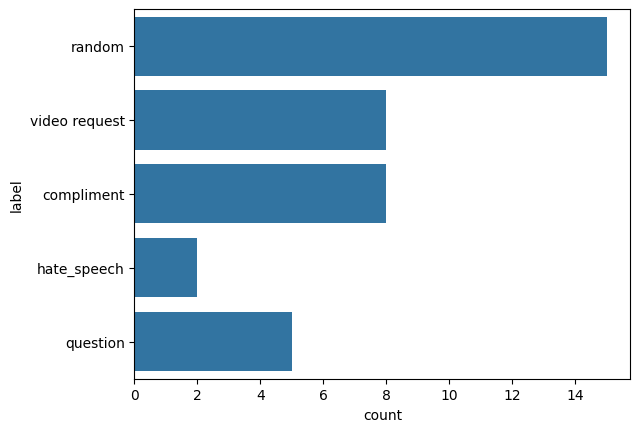

In [8]:
# plot distribution of labels
sns.countplot(df[y])

# write total number of samples
print(f"Total number of samples: {len(df)}")

In [9]:
# apply classifications
tqdm.pandas(desc='Assigning classifications')

X = "comment"
result_df = df[X].progress_apply(process_text)
df = pd.concat([df, result_df], axis=1)

Assigning classifications: 100%|██████████| 38/38 [01:05<00:00,  1.73s/it]


In [10]:
y_pred_values = [f"pred_{x}" for x in classifier_labels]

def get_highest_prediction_label(row):
  scores = {label: row[label] for label in y_pred_values}
  highest_label = max(scores, key=scores.get)
  return highest_label[5:]

In [11]:
y_pred = f"pred_{y}"

df[y_pred] = df.apply(get_highest_prediction_label, axis=1)
df[[y, y_pred]].head()

,label,pred_label
0,random,video request
1,random,video request
2,random,video request
3,random,video request
4,random,video request


<Axes: xlabel='count', ylabel='pred_label'>

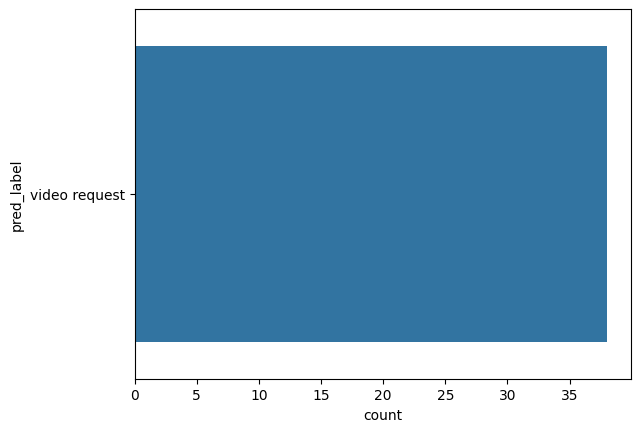

In [12]:
# plot distribution of predicted labels
sns.countplot(df[y_pred])

Find evaluation metrics

In [13]:
# Calculate accuracy
accuracy_score(df[y], df[y_pred])

0.21052631578947367

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_true=df[y], y_pred=df[y_pred])

In [15]:
# Generate a classification report, including precision, recall, and F1-score
print(classification_report(y_true=df[y], y_pred=df[y_pred]))

               precision    recall  f1-score   support

   compliment       0.00      0.00      0.00         8
  hate_speech       0.00      0.00      0.00         2
     question       0.00      0.00      0.00         5
       random       0.00      0.00      0.00        15
video request       0.21      1.00      0.35         8

     accuracy                           0.21        38
    macro avg       0.04      0.20      0.07        38
 weighted avg       0.04      0.21      0.07        38



/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

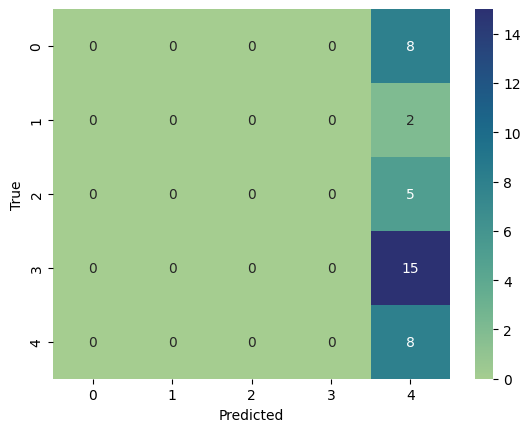

In [16]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Save processed data

In [17]:
# save processed data
df.to_csv("sample_processed.csv")

# Process dataset

In [ ]:
# new classifier model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", revision="c626438", device="mps")

In [75]:
# Read comments csv
df = pd.read_csv("./comments.csv")
df.head()

,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,channelId,videoId,textDisplay,textOriginal,parentId,canRate,viewerRating,likeCount,moderationStatus,publishedAt,updatedAt
0,ITS_ PINKY,https://yt3.ggpht.com/aFFlcFsCFl6x7CDRwNcVQUYG...,http://www.youtube.com/channel/UCjCRVkRpUlHqfp...,{'value': 'UCjCRVkRpUlHqfp_gdpaBPOA'},UCAQg09FkoobmLquNNoO4ulg,lKkIBuBKaYQ,Im sorry I&#39;m Indonesia,Im sorry I'm Indonesia,NaN,True,none,0,NaN,2023-10-15T04:04:09Z,2023-10-15T04:04:09Z
1,Usha m,https://yt3.ggpht.com/ytc/APkrFKYIjAZ35MFIBV8A...,http://www.youtube.com/channel/UCSv68BgvNWFcgG...,{'value': 'UCSv68BgvNWFcgGGdjxBvLyw'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,American English,American English,NaN,True,none,0,NaN,2023-10-15T04:00:52Z,2023-10-15T04:00:52Z
2,Thandar MayOo,https://yt3.ggpht.com/ytc/APkrFKYn_Cfx3FQDMQ4L...,http://www.youtube.com/channel/UCsboc7dHyi3Uel...,{'value': 'UCsboc7dHyi3UelUbOX-S_Mw'},UCAQg09FkoobmLquNNoO4ulg,qtlTMRyMWfU,thanks a lot teacher❤,thanks a lot teacher❤,NaN,True,none,0,NaN,2023-10-15T03:57:36Z,2023-10-15T03:57:36Z
3,my dreams mm,https://yt3.ggpht.com/P8FRE-AkxQArvRfemYoZ3mjJ...,http://www.youtube.com/channel/UCIzLlhvBSmWq7Q...,{'value': 'UCIzLlhvBSmWq7QOhP_kNerA'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,American,American,NaN,True,none,0,NaN,2023-10-15T03:26:21Z,2023-10-15T03:26:21Z
4,MrCodesYt,https://yt3.ggpht.com/49FlPza06B7Ol1-600H4zf1l...,http://www.youtube.com/channel/UCeeiZqY6_7mtGS...,{'value': 'UCeeiZqY6_7mtGSJLdw1x5Rw'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,"Australians: Truck 🚛, Lolly 🍬, Cookie 🍪, Jumpe...","Australians: Truck 🚛, Lolly 🍬, Cookie 🍪, Jumpe...",NaN,True,none,0,NaN,2023-10-15T02:42:07Z,2023-10-15T02:42:07Z


In [76]:
# input feature
X = "textOriginal"

In [77]:
# remove null values
df = df[df[X].notnull()]

# remove empty strings
df = df[df[X] != ""]

# find number of samples
len(df)

1000

Assigning classifications: 100%|██████████| 1000/1000 [00:03<00:00, 318.15it/s]


lang
en    733
id     26
tl     23
de     17
so     16
ro     15
ru     14
af     13
fr     12
nl     10
ca      9
cy      9
it      8
sw      8
tr      7
hr      7
th      6
et      6
sq      5
da      4
sl      4
sv      3
no      3
hu      3
pt      2
fi      2
bg      2
es      2
ar      2
vi      1
lv      1
ko      1
lt      1
sk      1
mk      1
pl      1
el      1
bn      1
Name: count, dtype: int64


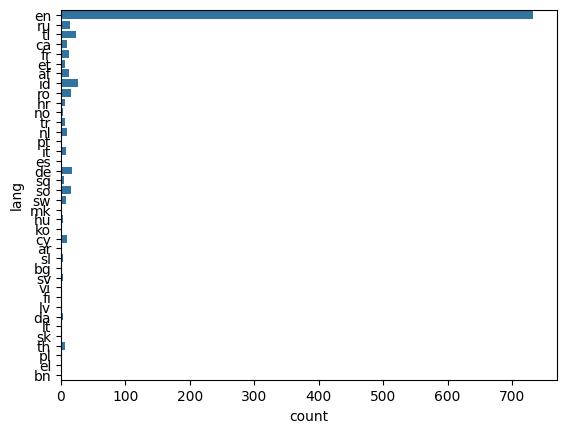

In [78]:
# use detect to find language of inputs
tqdm.pandas(desc='Detecting language')

# Define a function to detect language with error handling
def detect_language_with_error_handling(text):
    try:
        return detect(text)
    except LangDetectException as e:
        return None

# apply detect language function
df["lang"] = df[X].progress_apply(detect_language_with_error_handling)

# plot distribution of languages
sns.countplot(df["lang"])

# print number of samples per language
print(df["lang"].value_counts())

# filter out non-english comments
df = df[df["lang"] == "en"]

In [79]:
# new classifer labels
classifier_labels = [
    "Positive Feedback",
    "Questions",
    "Constructive Criticism",
    "Irrelevant",
    "Trolling",
    "Community",
    "Collaboration Offers",
    "Timestamps",
    "Error in the video",
    "New Subscriber",
    "Requests for Future Content",
    "Technical Issues",
    "Personal Story",
    "Promoting socials",
    "Joking",
]

# y_pred
y_pred = "pred_label"

# print number of labels
print(f"Number of labels: {len(classifier_labels)}")

Number of labels: 15


In [80]:
# use the classifier to return the classifier label with the highest score
def predict(text: str):
    classifications = classifier(text, classifier_labels)
    scores = classifications["scores"]
    output_labels = classifications["labels"]

    # find index of highest score
    highest_score_index = scores.index(max(scores))

    # return label with highest score
    return output_labels[highest_score_index]


In [81]:
# apply classifications on all rows of feature since none are empty
tqdm.pandas(desc='Assigning classifications')

predictions = pd.DataFrame()

# no of rows to run predictions on
n = 100

# run predictions on the first n rows with progress apply
predictions[y_pred] = df[X][:n].progress_apply(predict)
df = pd.concat([df[:n], predictions], axis=1)

Assigning classifications: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


<Axes: xlabel='count', ylabel='pred_label'>

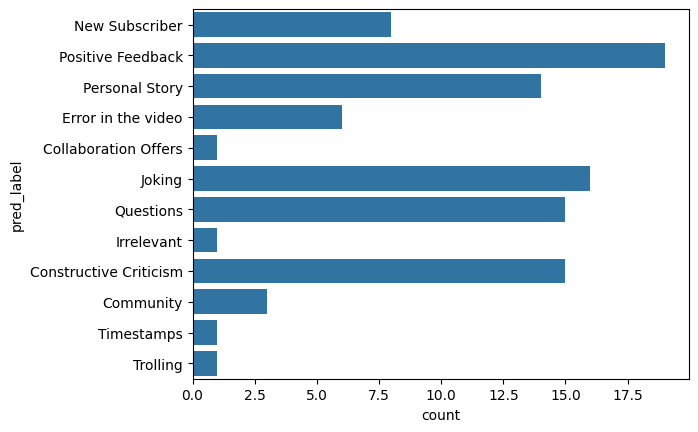

In [82]:
# plot distribution of predicted labels
sns.countplot(df[y_pred])

In [83]:
# Show label beside predicted label
df[[X, y_pred]]

,textOriginal,pred_label
0,Im sorry I'm Indonesia,New Subscriber
1,American English,New Subscriber
2,thanks a lot teacher❤,Positive Feedback
3,American,Personal Story
4,"Australians: Truck 🚛, Lolly 🍬, Cookie 🍪, Jumpe...",Positive Feedback
...,...,...
124,Ok i speak both 🗿,Joking
126,Its fresh FROIZZ,New Subscriber
127,Thank you Marina I am from uzbekistan I am a g...,Positive Feedback
128,"Amrican-Eggplant \nBritish-aubergine\nMe-Dick,...",Joking


In [84]:
# save processed data
df.to_csv("comments_processed.csv")

In [87]:
tokens = classifier.tokenizer.tokenize("I just wanted to say a big thank you for your amazing YouTube content that has helped me improve my English so much! 🙌📚 Your videos are awesome, and I'm truly grateful for all the valuable lessons and tips you share. Keep up the fantastic work! 💓👏🌟")
ids = classifier.tokenizer.convert_tokens_to_ids(tokens)

len(ids)

64

In [88]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [178]:
# np random seed
import numpy as np
np.random.seed(0)

In [179]:
# Read comments csv
df = pd.read_csv("./comments.csv")
df.head()

,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,channelId,videoId,textDisplay,textOriginal,parentId,canRate,viewerRating,likeCount,moderationStatus,publishedAt,updatedAt
0,ITS_ PINKY,https://yt3.ggpht.com/aFFlcFsCFl6x7CDRwNcVQUYG...,http://www.youtube.com/channel/UCjCRVkRpUlHqfp...,{'value': 'UCjCRVkRpUlHqfp_gdpaBPOA'},UCAQg09FkoobmLquNNoO4ulg,lKkIBuBKaYQ,Im sorry I&#39;m Indonesia,Im sorry I'm Indonesia,NaN,True,none,0,NaN,2023-10-15T04:04:09Z,2023-10-15T04:04:09Z
1,Usha m,https://yt3.ggpht.com/ytc/APkrFKYIjAZ35MFIBV8A...,http://www.youtube.com/channel/UCSv68BgvNWFcgG...,{'value': 'UCSv68BgvNWFcgGGdjxBvLyw'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,American English,American English,NaN,True,none,0,NaN,2023-10-15T04:00:52Z,2023-10-15T04:00:52Z
2,Thandar MayOo,https://yt3.ggpht.com/ytc/APkrFKYn_Cfx3FQDMQ4L...,http://www.youtube.com/channel/UCsboc7dHyi3Uel...,{'value': 'UCsboc7dHyi3UelUbOX-S_Mw'},UCAQg09FkoobmLquNNoO4ulg,qtlTMRyMWfU,thanks a lot teacher❤,thanks a lot teacher❤,NaN,True,none,0,NaN,2023-10-15T03:57:36Z,2023-10-15T03:57:36Z
3,my dreams mm,https://yt3.ggpht.com/P8FRE-AkxQArvRfemYoZ3mjJ...,http://www.youtube.com/channel/UCIzLlhvBSmWq7Q...,{'value': 'UCIzLlhvBSmWq7QOhP_kNerA'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,American,American,NaN,True,none,0,NaN,2023-10-15T03:26:21Z,2023-10-15T03:26:21Z
4,MrCodesYt,https://yt3.ggpht.com/49FlPza06B7Ol1-600H4zf1l...,http://www.youtube.com/channel/UCeeiZqY6_7mtGS...,{'value': 'UCeeiZqY6_7mtGSJLdw1x5Rw'},UCAQg09FkoobmLquNNoO4ulg,ct_9X-gwKMs,"Australians: Truck 🚛, Lolly 🍬, Cookie 🍪, Jumpe...","Australians: Truck 🚛, Lolly 🍬, Cookie 🍪, Jumpe...",NaN,True,none,0,NaN,2023-10-15T02:42:07Z,2023-10-15T02:42:07Z


Detecting language: 100%|██████████| 1000/1000 [00:03<00:00, 317.44it/s]


lang
en    740
id     26
tl     23
de     18
so     15
fr     14
ro     14
ru     13
af     13
ca      9
nl      8
it      8
sw      8
sq      7
hr      7
cy      7
tr      6
th      6
da      5
et      4
bg      3
no      3
hu      3
sv      2
pt      2
sl      2
ar      2
es      2
ko      1
mk      1
vi      1
fi      1
lv      1
lt      1
cs      1
pl      1
el      1
bn      1
Name: count, dtype: int64


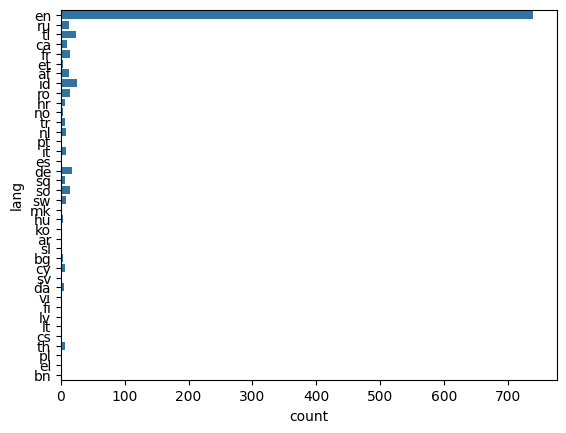

In [180]:
# use detect to find language of inputs
tqdm.pandas(desc='Detecting language')

# Define a function to detect language with error handling
def detect_language_with_error_handling(text):
    try:
        return detect(text)
    except LangDetectException as e:
        return None

# apply detect language function
df["lang"] = df[X].progress_apply(detect_language_with_error_handling)

# plot distribution of languages
sns.countplot(df["lang"])

# print number of samples per language
print(df["lang"].value_counts())

# filter out non-english comments
df = df[df["lang"] == "en"]

In [181]:
# get the embedding of the label
df["embedding"] = df[X].progress_apply(lambda x: model.encode(x))

Detecting language: 100%|██████████| 740/740 [00:06<00:00, 106.67it/s]


In [182]:
# perform k-means clustering on the embeddings
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df["embedding"].tolist())

# add cluster labels to dataframe
df["cluster"] = kmeans.labels_

/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [183]:
# save X, cluster as cluster.csv
df[[X, "cluster"]].to_csv("cluster.csv")

In [184]:
# find value counts of clusters
df["cluster"].value_counts()

cluster
1    229
3    197
0    176
4     74
2     64
Name: count, dtype: int64

In [185]:
# cluster 1 seems to be very effective in picking out actionables when n = 5 for kmeans

In [186]:
# # filter out comments with cluster 1
# df = df[df["cluster"] == 1]

# # apply classifier on filtered comments
# tqdm.pandas(desc='Assigning classifications')

# predictions = pd.DataFrame()

# # no of rows to run predictions on
# n = -1

# # run predictions on the first n rows with progress apply
# predictions[y_pred] = df[X][:n].progress_apply(predict)
# df = pd.concat([df[:n], predictions], axis=1)

# # plot distribution of predicted labels
# sns.countplot(df[y_pred])

# # Show label beside predicted label
# df[[X, y_pred]]

In [187]:
# save processed data
df.to_csv("cluster_classify.csv")

In [188]:
# open cluster_classify_best.csv and save only the X, y_pred and cluster columns
df = pd.read_csv("cluster_classify_best.csv")
df = df[[X, y_pred, "cluster"]]
df.to_csv("cluster_classify_best.csv")